In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [2]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.63.109.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.63.109.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement et correction des données

Le dataset utilisé contient les prix des actions des 81 principales compagnies du NASDAQ100. La valeur de l'index du NASDAQ est utilisé comme cible.  
La fréquence des information est d'une minute, depuis le 26 juillet 2016 jusqu'au 22 décembre 2016, soit 105 jours au total (les samedi et dimanche ne sont pas comptés, ainsi que le 25 novembre qui ne possède que 210 données et le 22 décembre qui n'en possède que 180).

**1. Chargement des données**

In [3]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/nasdaq100_padding.csv"

rm: cannot remove '*.csv': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   184  100   184    0     0    958      0 --:--:-- --:--:-- --:--:--   958
100 22.6M  100 22.6M    0     0  18.5M      0  0:00:01  0:00:01 --:--:-- 27.5M


**2. Analyse et correction des données**

In [4]:
# Création de la série sous Pandas
df_etude = pd.read_csv("nasdaq100_padding.csv",dtype="float32")
df_etude

AAL        AAPL        ADBE  ...       XLNX       YHOO          NDX
0      35.980000   96.800003   97.800003  ...  48.610001  38.009998  4665.054199
1      35.931000   96.889999   97.800003  ...  48.740002  38.139999  4665.054199
2      35.904400   96.949997   97.570000  ...  48.990002  38.150002  4665.826172
3      35.889999   96.970001   97.550003  ...  48.950001  38.195000  4667.081055
4      36.007999   96.959999   97.730003  ...  48.889999  38.320000  4664.491211
...          ...         ...         ...  ...        ...        ...          ...
40555  48.502998  115.879997  104.190002  ...  59.919998  38.529999  4921.811035
40556  48.514999  115.875000  104.180000  ...  59.929001  38.509998  4921.580078
40557  48.529999  115.875000  104.150002  ...  59.934502  38.508400  4921.883789
40558  48.560001  115.919998  104.190002  ...  59.939999  38.505001  4922.949219
40559  48.560001  115.910004  104.169998  ...  59.950001  38.509998  4922.941895

[40560 rows x 82 columns]

Affiche les types :

In [5]:
df_etude.dtypes

AAL     float32
AAPL    float32
ADBE    float32
ADI     float32
ADP     float32
         ...   
WDC     float32
WFM     float32
XLNX    float32
YHOO    float32
NDX     float32
Length: 82, dtype: object

**5. Affiche les données**

In [6]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['NDX'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Séparation des données de test et d'entrainement

In [7]:
# Sépare les données en entrainement et tests
pourcentage = 0.9
temps_separation = int(len(df_etude.values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 36504
Taille de la validation : 4056


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [8]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

In [9]:
print(serie_entrainement_X_norm.shape)
print(serie_test_X_norm.shape)

(36504, 82)
(4056, 82)


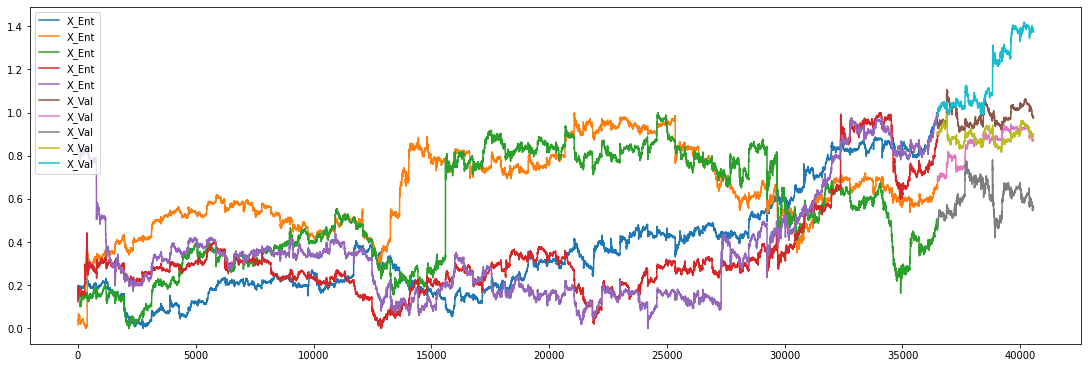

In [10]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Filtrage L1

**1. Codage de la fonction de filtrage L1**

In [11]:
from itertools import chain
from cvxopt import blas, lapack, solvers
from cvxopt import matrix, spmatrix, sin, mul, div, normal, spdiag


def get_second_derivative_matrix(n):
    """
    :param n: The size of the time series
    :return: A matrix D such that if x.size == (n,1), D * x is the second derivate of x
    """
    m = n - 2
    D = spmatrix(list(chain(*[[1, -2, 1]] * m)),
                 list(chain(*[[i] * 3 for i in range(m)])),
                 list(chain(*[[i, i + 1, i + 2] for i in range(m)])))
    return D


def _l1tf(corr, delta):
    """
        minimize    (1/2) * ||x-corr||_2^2 + delta * sum(y)
        subject to  -y <= D*x <= y
    Variables x (n), y (n-2).
    :param x:
    :return:
    """

    n = corr.size[0]
    m = n - 2

    D = get_second_derivative_matrix(n)

    P = D * D.T
    q = -D * corr

    G = spmatrix([], [], [], (2*m, m))
    G[:m, :m] = spmatrix(1.0, range(m), range(m))
    G[m:, :m] = -spmatrix(1.0, range(m), range(m))

    h = matrix(delta, (2*m, 1), tc='d')

    res = solvers.qp(P, q, G, h)

    return corr - D.T * res['x']

def l1tf(corr, delta):
    """
    :param corr: Corrupted signal, should be a numpy array / pandas Series
    :param delta: Strength of regularization
    :return: The filtered series
    """

    m = float(corr.min())
    M = float(corr.max())
    denom = M - m
    # if denom == 0, corr is constant
    t = (corr-m) / (1 if denom == 0 else denom)

    if isinstance(corr, np.ndarray):
        values = matrix(t)
    elif isinstance(corr, pd.Series):
        values = matrix(t.values[:])
    else:
        raise ValueError("Wrong type for corr")

    values = _l1tf(values, delta)
    values = values * (M - m) + m

    if isinstance(corr, np.ndarray):
        values = np.asarray(values).squeeze()
    elif isinstance(corr, pd.Series):
        values = pd.Series(values, index=corr.index, name=corr.name)

    return values

**2. Exemple d'application**

In [12]:
cible_filtre = l1tf(serie_entrainement_X_norm[0:100,-1],0.005)

     pcost       dcost       gap    pres   dres
 0: -4.5794e-02 -1.0579e+00  2e+02  1e+01  2e-15
 1: -1.9252e-02 -1.0359e+00  5e+00  3e-01  3e-15
 2: -5.3082e-03 -6.8460e-01  7e-01  4e-17  2e-15
 3: -6.8190e-03 -4.5693e-02  4e-02  1e-17  1e-15
 4: -1.2742e-02 -1.8493e-02  6e-03  1e-17  2e-16
 5: -1.4801e-02 -1.5886e-02  1e-03  2e-17  1e-16
 6: -1.5227e-02 -1.5361e-02  1e-04  2e-17  1e-16
 7: -1.5277e-02 -1.5290e-02  1e-05  2e-17  1e-16
 8: -1.5282e-02 -1.5283e-02  7e-07  2e-17  1e-16
 9: -1.5282e-02 -1.5282e-02  3e-08  2e-17  2e-16
Optimal solution found.


In [13]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index[0:100],y=serie_entrainement_X_norm[0:100,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[0:100],y=cible_filtre,line=dict(color='red', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**3. Filtrage de la cible**

In [14]:
cible_filtre_ent = l1tf(serie_entrainement_X_norm[:,-1],0.005)
cible_filtre_val = l1tf(serie_test_X_norm[:,-1],0.005)

     pcost       dcost       gap    pres   dres
 0: -2.4397e-01 -3.7835e+02  8e+04  2e+02  2e-14
 1: -1.1956e-01 -3.7473e+02  2e+03  4e+00  3e-14
 2: -3.6322e-02 -2.5000e+02  2e+02  6e-16  2e-14
 3: -4.9158e-02 -1.3328e+01  1e+01  2e-16  1e-14
 4: -1.2943e-01 -2.2256e+00  2e+00  2e-16  2e-15
 5: -2.1072e-01 -6.2816e-01  4e-01  2e-16  3e-16
 6: -2.6069e-01 -3.5186e-01  9e-02  2e-16  2e-16
 7: -2.7702e-01 -3.0268e-01  3e-02  2e-16  3e-16
 8: -2.8107e-01 -2.8919e-01  8e-03  2e-16  3e-16
 9: -2.8213e-01 -2.8487e-01  3e-03  2e-16  3e-16
10: -2.8248e-01 -2.8324e-01  8e-04  2e-16  3e-16
11: -2.8257e-01 -2.8279e-01  2e-04  2e-16  3e-16
12: -2.8260e-01 -2.8263e-01  3e-05  2e-16  3e-16
13: -2.8261e-01 -2.8261e-01  5e-06  3e-16  3e-16
14: -2.8261e-01 -2.8261e-01  6e-07  2e-16  3e-16
15: -2.8261e-01 -2.8261e-01  2e-08  2e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0126e-01 -4.1894e+01  9e+03  9e+01  9e-15
 1: -4.6876e-02 -4.1472e+01  2e+02  2e+00  2e-1

In [15]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index[:temps_separation],y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

fig.add_trace(go.Scatter(x=df_etude.index[:temps_separation],y=cible_filtre_ent,line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=cible_filtre_val,line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**4. Ajout de la cible filtrée aux données**

In [16]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)-1):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm.append(cible_filtre_ent)
serie_test_X_norm.append(cible_filtre_val)

serie_entrainement_X_norm.append(serie_entrainement_X[:,-1])
serie_test_X_norm.append(serie_test_X[:,-1])


serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

In [17]:
import plotly.graph_objects as go

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index[:temps_separation],y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

fig.add_trace(go.Scatter(x=df_etude.index[:temps_separation],y=serie_entrainement_X_norm[:,-2],line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-2],line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Création des datasets

Les datasets sont créés de la manière suivante :

  <img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/ConstructionDataset.png?raw=true' width=500/>

**1. Exemple de dataset**

In [18]:
X1 = np.linspace(1,100,100)
X2 = np.linspace(101,200,100)
X3 = np.linspace(201,300,100)
Y = np.linspace(301,400,100)

X1 = tf.expand_dims(X1,-1)
X2 = tf.expand_dims(X2,-1)
X3 = tf.expand_dims(X3,-1)
Y = tf.expand_dims(Y,-1)

Serie_X = tf.concat([X1,X2,X3],axis=1)
Serie_Y = Y
print(Serie_X.shape)

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),((X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT-1)}
# Y = YT

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

test_dataset = prepare_dataset_XY(Serie_X,Serie_Y,10,1,1,1)

print(len(list(test_dataset.as_numpy_iterator())))
for element in test_dataset.take(2):
  print(element)

(100, 3)
89
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  1., 101., 201.],
        [  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.]]])>, <tf.Tensor: shape=(1, 10, 1), dtype=float64, numpy=
array([[[301.],
        [302.],
        [303.],
        [304.],
        [305.],
        [306.],
        [307.],
        [308.],
        [309.],
        [310.]]])>), <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[311.]]])>)
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.],
        [ 11., 111., 211.]]])>, <tf.Tensor: shape=(1, 10,

**2. Préparation des datasets**

In [19]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [20]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 10
longueur_sortie = 1
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [21]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1

285
(128, 10, 82)
(128, 10, 1)
(128, 1, 1)


In [22]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT
  print(element[1].shape)               # YT+1

31
(128, 10, 82)
(128, 10, 1)
(128, 1, 1)


**3. Préparation des X/Y**

In [23]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(36480, 10, 82)
(36480, 10, 1)
(36480, 1, 1)


In [24]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(3968, 10, 82)
(3968, 10, 1)
(3968, 1, 1)


# Affichage des séries

In [ ]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(np.linspace(0,longueur_sequence,longueur_sequence),x_train[0][0,:,0:3],label="X_train (X)")
ax.plot(np.linspace(0,longueur_sequence,longueur_sequence),x_train[1][0,:,:],label="X_train (Y)")

ax.plot(np.linspace(longueur_sequence+1,longueur_sequence+2,1),y_train[0,:,:],label="Y_train",marker="*")

ax.legend()
plt.show()

# Création du modèle HRHN

Le modèle HRHN est décrit dans ce document de recherche : [Hierarchical Attention-Based Recurrent Highway Networks for Time Series Prediction](https://arxiv.org/pdf/1806.00685)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Mod%C3%A8leHRHN1.png?raw=true' width=700>

**1. Création de l'encodeur**

L'encodeur a pour but de créer des représentations cachées des séries exogènes qui prennent en compte les relations spatiales entre ces séries ainsi que les relations temporelles.  
Les relations spatiales sont extraitent à l'aide d'un ensemble de réseaux de convolution qui produisent des représentations w1, w2... w(T-1).  
Ces représentations sont ensuites codées par un réseau RHN à 3 couches afin d'en extraire les relations temporelles. En sortie de ce réseau RHN, on extrait 3 tenseurs dont chacun contient les (T-1) états cachés de chaque couche du réseau RHN.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_VueEnsemble.png?raw=true'>

***a. Création des CNN parallèlisés***

La structure d'un réseau de convolution est composée de trois couches CNN-1D + Max-pooling :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_CNN1.png?raw=true'>

L'intégration de caque réseau dans Keras est parallélisée :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_CNN2.png?raw=true'>

In [25]:
# Arguments de la méthode __init__
#   dim_filtres_cnn   :   liste dimension des filtres ex: [3,3,3]
#   nbr_filtres_cnn   :   liste nbr de filtre sur chaque couche ex: [16,32,64]
#   dim_max_pooling   :   liste dimension max pooling après chaque couche ex: [3,3,3]

class Encodeur_CNN(tf.keras.layers.Layer):
  def __init__(self, dim_filtres_cnn, nbr_filtres_cnn, dim_max_pooling,dim_motif):
    self.dim_filtres_cnn = dim_filtres_cnn
    self.nbr_filtres_cnn = nbr_filtres_cnn
    self.dim_max_pooling = dim_max_pooling
    self.dim_motif = dim_motif
    super().__init__()                # Appel du __init__() de la classe Layer
  
  # Création de Tin réseaux de convolution + max_pooling en //
  ############################################################
  def build(self,input_shape):
    convs = []
    input_cnns = []

    # Création des Tin entrées des réseaux CNN
    for i in range(input_shape[1]):
        input_cnns.append(tf.keras.Input(shape=(input_shape[2],1)))       # input = Tin*(batch_size,#dim,1)

    # Création des Tin réseaux CNN
    for i in range(input_shape[1]):
      conv = tf.keras.layers.Conv1D(filters=self.nbr_filtres_cnn[0],      # conv : (batch_size,#dim,16)
                                    kernel_size=self.dim_filtres_cnn[0],
                                    activation='relu',
                                    padding='same',
                                    strides=1)(input_cnns[i])
      conv = tf.keras.layers.MaxPool1D(pool_size=self.dim_max_pooling[0],      # conv : (batch_size,#pooling1,16)
                                       padding='same')(conv)
      for n in range(1,len(self.dim_filtres_cnn)):
        conv = tf.keras.layers.Conv1D(filters=self.nbr_filtres_cnn[n],    # conv : (batch_size,#pooling_x,dim_filtres_cnn[n])
                                      kernel_size=self.dim_filtres_cnn[n],
                                      activation='relu',
                                      padding='same',
                                      strides=1)(conv)
        conv = tf.keras.layers.MaxPool1D(pool_size=self.dim_max_pooling[n],    # conv : (batch_size,#pooling_x,dim_filtres_cnn[n])
                                         padding='same')(conv)
      convs.append(conv)
    
    # Création de la sortie concaténée des Tin réseaux CNN
    out = tf.convert_to_tensor(convs)                                     # out : (Tin,batch_size,#pooling,64)
    out = tf.transpose(out,perm=[1,0,2,3])                                # out : (batch_size,Tin,#pooling,64)
    out = tf.keras.layers.Reshape(                                        # out : (batch_size,Tin,#pooling*64)
        target_shape=(out.shape[1],out.shape[2]*out.shape[3]))(out)

    if self.dim_motif == 0:
      out = tf.keras.layers.Dense(units=out.shape[2])(out)                  # out : (batch_size,Tin,dim_motif = #pooling*64) 
    else:
      out = tf.keras.layers.Dense(units=self.dim_motif)(out)                # out : (batch_size,Tin,dim_motif) 

    # Création du modèle global
    self.conv_model = tf.keras.Model(inputs=input_cnns,outputs=out)

    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:  Entrée séries exogènes  : (batch_size,Tin,#dim)
  # Sorties :
  #     w:      Sorties des motifs CNN  : (batch_size,Tin,#dim_motif)
  #                                       (taille dernier filtre=64)
  def call(self, input):
    # Coupes temporelles sur les séries exogènes
    # au format : Tin*(batch_size,#dim,1)
    input_list = []
    for i in range(input.shape[1]):
      input_list.append(tf.transpose(input[:,i:i+1,:],perm=[0,2,1]))      # (batch_size,#dim,1)
    # Convolutions spatiales des séries exogènes
    w = self.conv_model(input_list)                                       # (batch_size,Tin,dim_motif)
    return w

***b. Création des cellules RHN***

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_RHN.png?raw=true'>

On crée une cellule RHN en reprenant le code précédent auquel :  
- On ajoute la possibilité de retourner tous les états cachés de chaque couche
- On ajoute la prise en compte de la dimension d'entrée correspondant à la dimension des motifs en sortie des réseaux CNN (dim_motif)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Structure_RHN4.png?raw=true'>

In [26]:
class Cellule_RHN(tf.keras.layers.Layer):
  def __init__(self, dim_RHN, nbr_couches, return_all_states = False, dim_input=1):
    self.dim_RHN = dim_RHN
    self.nbr_couches = nbr_couches
    self.dim_input = dim_input
    self.return_all_states = return_all_states
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Wh = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wh")       # (#dim, #RHN)
    self.Wt = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wt")       # (#dim, #RHN)
    self.Wc = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wc")       # (#dim, #RHN)

    self.Rh = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rh")      # (n_couches,#RHN, #RHN)
    self.Rt = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rt")      # (n_couches,#RHN, #RHN)
    self.Rc = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rc")      # (n_couches,#RHN, #RHN)

    self.bh = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bh")        # (n_couches,#RHN, 1)
    self.bt = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bt")        # (n_couches,#RHN, 1)
    self.bc = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bc")        # (n_couches,#RHN, 1)

    super().build(input_shape)        # Appel de la méthode build()

    # Initialisation des masques de dropout
  def InitMasquesDropout(self,drop=0.0):
    self.Wh_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Wt_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Wc_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Rh_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)
    self.Rt_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)
    self.Rc_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)

  # Entrées :
  #     input:          Entrées X[t]        : (batch_size,1,#dim)
  #     init_hidden:    Etat caché Init.    : (batch_size,#RHN)
  # Sorties :
  #     sL:             Etat caché de la dernière couche       : (batch_size,#RHN) 
  #           ou        Etats cachés de chaque couche SL[t]    : (batch_size,nbr_couches,#RHN)
  def call(self, input, init_hidden=None):
    # Construction d'un vecteur d'état nul si besoin
    if init_hidden == None:
      init_hidden = tf.matmul(tf.zeros(shape=(self.dim_RHN,input.shape[2])), # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
                              tf.transpose(input,perm=[0,2,1]))
      init_hidden = tf.squeeze(init_hidden,-1)                               # (batch_size,#RHN,1) => (batch_size,#RHN)
  
    liste_sl = []                                                            # Liste pour  enregistrer les états cachés de chaque couche
    # Calcul de hl, tl et cl
    for i in range(self.nbr_couches):
      if i==0:
        # Applique le masque aux poids
        Rh = tf.multiply(self.Rh_[0,:,:],self.Rh[0,:,:])                      # (#RHN,1)_x_(#RHN,#RHN) = (#RHN,#RHN)
        Rt = tf.multiply(self.Rt_[0,:,:],self.Rt[0,:,:])
        Rc = tf.multiply(self.Rc_[0,:,:],self.Rc[0,:,:])

        Wh = tf.multiply(self.Wh_,self.Wh)                                    # (#dim,1)_x_(#dim,#RHN) = (#dim,#RHN)
        Wt = tf.multiply(self.Wt_,self.Wt)
        Wc = tf.multiply(self.Wc_,self.Wc)
   
        # Calcul de hl
        hl = tf.matmul(Rh,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        hl = hl + self.bh[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        hl = hl + tf.matmul(tf.transpose(Wh),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        hl = tf.squeeze(hl,-1)                                              # (batch_size,#RHN)
        hl = K.tanh(hl)

        # Calcul de tl
        tl = tf.matmul(Rt,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        tl = tl + self.bt[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        tl = tl + tf.matmul(tf.transpose(Wt),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        tl = tf.squeeze(tl,-1)                                              # (batch_size,#RHN)
        tl = tf.keras.activations.sigmoid(tl)

        # Calcul de cl
        cl = tf.matmul(Rc,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        cl = cl + self.bc[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        cl = cl + tf.matmul(tf.transpose(Wc),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        cl = tf.squeeze(cl,-1)                                              # (batch_size,#RHN)
        cl = tf.keras.activations.sigmoid(cl)

      else:
        # Applique le masque aux poids
        Rh = tf.multiply(self.Rh_[i,:,:],self.Rh[i,:,:])
        Rt = tf.multiply(self.Rt_[i,:,:],self.Rt[i,:,:])
        Rc = tf.multiply(self.Rc_[i,:,:],self.Rc[i,:,:])

        # Calcul de hl
        hl = tf.matmul(Rh,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        hl = hl + self.bh[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        hl = tf.squeeze(hl,-1)                                              # (batch_size,#RHN)
        hl = K.tanh(hl)

        # Calcul de tl
        tl = tf.matmul(Rt,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        tl = tl + self.bt[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        tl = tf.squeeze(tl,-1)                                              # (batch_size,#RHN)
        tl = tf.keras.activations.sigmoid(tl)

        # Calcul de cl
        cl = tf.matmul(Rc,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        cl = cl + self.bc[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        cl = tf.squeeze(cl,-1)                                              # (batch_size,#RHN)
        cl = tf.keras.activations.sigmoid(cl)
      
      # Calcul de sl
      sl = tf.keras.layers.multiply([hl,tl])                                # (batch_size,#RHN)
      sl = sl + tf.keras.layers.multiply([init_hidden,cl])                  # (batch_size,#RHN)
      liste_sl.append(sl)       # Sauvegarde l'état caché de la couche courante
      init_hidden = sl
    if self.return_all_states == False:
      return sl
    else:
      liste_sl = tf.convert_to_tensor(liste_sl)                             # (nbr_couches,batch_size,#RHN)
      liste_sl = tf.transpose(liste_sl,perm=[1,0,2])                        # (batch_size,nbr_couches,#RHN)
      return liste_sl

***c. Création de l'encodeur : Convolutions + RHN***

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_VueEnsemble.png?raw=true'>

In [27]:
# Arguments de la méthode __init__
#   dim_filtres_cnn   :   liste dimension des filtres ex: [3,3,3]
#   nbr_filtres_cnn   :   liste nbr de filtre sur chaque couche ex: [16,32,64]
#   dim_max_pooling   :   liste dimension max pooling après chaque couche ex: [3,3,3]
#   dim_motif         :   dimension du motif en sortie du CNN
#   dim_RHN           :   dimension du vecteur caché RHN
#   nbr_couches_RHN   :   nombre de couches du RHN
#   dropout           :   dropout variationnel pour le RHN ex: [0.1]

class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_filtres_cnn, nbr_filtres_cnn, dim_max_pooling, dim_motif,dim_RHN,nbr_couches_RHN, dropout=0.0):
    self.dim_filtres_cnn = dim_filtres_cnn
    self.nbr_filtres_cnn = nbr_filtres_cnn
    self.dim_max_pooling = dim_max_pooling
    self.dim_motif = dim_motif
    self.dim_RHN = dim_RHN
    self.nbr_couches_RHN = nbr_couches_RHN
    self.dropout = dropout
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.encodeur_cnn = Encodeur_CNN(dim_filtres_cnn=self.dim_filtres_cnn,nbr_filtres_cnn=self.nbr_filtres_cnn,dim_max_pooling=self.dim_max_pooling,dim_motif=self.dim_motif)
    self.RHN = Cellule_RHN(dim_RHN=self.dim_RHN,nbr_couches=self.nbr_couches_RHN,return_all_states=True,dim_input=self.dim_motif)
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:          Entrées X         : (batch_size,Tin,#dim)
  # Sorties :
  #     hidden_states   Vecteurs cachés   : (batch_size,nbr_couches,Tin,#RHN)
  def call(self, input):
    # Convolutions spatiales des séries exogènes
    w = self.encodeur_cnn(input)      #  (batch_size,Tin,dim_motif)

    # Encodage des motifs CNN avec les cellules RHN
    sequence = []
    hidden = None

    # Initialisation des masques de dropout pour tous les pas de temps
    self.RHN.InitMasquesDropout(self.dropout)

    # Applique la cellule RHN à chaque pas de temps
    for i in range(input.shape[1]):
      hidden = self.RHN(w[:,i:i+1,:],hidden)          # Envoie (batch_size,1,dim_motif)
      sequence.append(hidden)                         # Sauve (batch_size,nbr_couches,#RHN)

      # Le premier état caché du prochain instant
      # est l'état caché de la dernière couche précédente
      hidden = hidden[:,self.nbr_couches_RHN-1,:]       # (batch_size,#RHN)

    # Traite le format des vecteurs cachés de l'encodeur
    sequence = tf.convert_to_tensor(sequence)               # (Tin,batch_size,nbr_couches,#RHN)
    hidden_states = tf.transpose(sequence,perm=[1,2,0,3])   # (batch_size,nbr_couches,Tin,#RHN)  

    return hidden_states

**Test de l'encodeur**

In [28]:
x_train[0].shape

(36480, 10, 82)

In [29]:
x_train[0][0:5,:,:].shape

(5, 10, 82)

In [30]:
s = Encodeur(dim_filtres_cnn=[16,32,64],nbr_filtres_cnn=[3,3,3],dim_max_pooling=[3,3,3],dim_motif=3,dim_RHN=128,nbr_couches_RHN=3,dropout=0.0)(x_train[0][0:5,:,:])
s.shape

TensorShape([5, 3, 10, 128])

In [31]:
entrees_sequences = tf.keras.layers.Input(shape=(10,81))
sortie = Encodeur(dim_filtres_cnn=[16,32,64],nbr_filtres_cnn=[3,3,3],dim_max_pooling=[3,3,3],dim_motif=3,dim_RHN=128,nbr_couches_RHN=3,dropout=0.0)(entrees_sequences)
model = tf.keras.Model(entrees_sequences,sortie)

**2. Création du décodeur**

Le décodeur prend en entrée et à chaque pas de temps :  
- Le tenseur en sortie de l'encodeur RHN qui contient l'ensemble des vecteurs cachés des différentes couches : (batch_size,Nbr_couches,Tin,#RHN)
- L'état caché de la dernière couche du décodeur RHN précédent : (batch_size,#RHN)
- La valeur de la série cible à l'instant courant : (batch_size,1,1)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_VueEnsembleDecodeur2.png?raw=true'>

**a. Création de la couche d'attention hiérarchique**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_AttentionHierarchique.png?raw=true'>

On commence par créer la fonction permettant de calculer les scores. Cette fonction sera appelée avec la méthode TimeDistributed de Keras.

In [32]:
class CalculScore(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.T = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="T")            # (#RHN, #RHN)
    self.U = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="U")            # (#RHN, #RHN)
    self.b = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="b")                         # (#RHN, 1)
    self.v = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="v")                         # (#RHN, 1)
    super().build(input_shape)        # Appel de la méthode build()

  #     hid_state:  Etat initial RHN          : (batch_size,#RHN)
  def SetInitState(self,hid_state):
    self.hid_state = hid_state

  def compute_output_shape(self,input_shape):
    return(input_shape[0],1)

  # Entrées :
  #     input:      1 sortie encodeur RHN     : (batch_size,#RHN)
  # Sorties :
  #     score:      score                     : (batch_size,1,1)
  def call(self, input):
    score = tf.matmul(self.U,tf.expand_dims(input,-1))                      # (#RHN,#RHN)x(batch_size,#RHN,1) = (batch_size,#RHN,1)
    score = score + tf.matmul(self.T,tf.expand_dims(self.hid_state,-1))     # (batch_size,#RHN,1)
    score = score + self.b                                                  # (batch_size,#RHN,1)
    score = K.tanh(score)
    score = tf.matmul(tf.transpose(self.v),score)                           # (1,#RHN)x(batch_size,#RHN,1) = (batch_size,1,1)
    return tf.squeeze(score,-1)                                             # (batch_size,1)

On crée maintenant la couche d'attention hiérarchique :

In [33]:
class AttentionHierarchique(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_score = CalculScore()
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:      Sorties d'une couche encodeur RHN       : (batch_size,Tin,#RHN)
  #     hid_state:  Etat initial RHN                        : (batch_size,#RHN)
  # Sorties :
  #     vc:         SousVecteur contexte                    : (batch_size,1,RHN)
  def call(self, input, hid_state):
    # Calcul des scores
    self.couche_score.SetInitState(hid_state)
    scores = tf.keras.layers.TimeDistributed(self.couche_score)(input)        # (batch_size,Tin,#RHN) : Timestep = Tin
                                                                              # (batch_size,#RHN) envoyé Tin fois
                                                                              # (batch_size,Tin,1) retourné
    scores = tf.keras.activations.softmax(scores,axis=1)                      # (batch_size,Tin,1)

    # Applique les scores aux sorties de la couche RHN
    poids = tf.multiply(input,scores)             # (batch_size,Tin,#RHN)_x_(batch_size,Tin,1) = (batch_size,Tin,#RHN)

    # Calcul le sous-vecteur contexte
    vc = K.sum(poids,axis=1)                      # (batch_size,#RHN)
    return tf.expand_dims(vc,1)                   # (batch_size,1,#RHN)

**b. Création du décodeur**

Dans le décodeur, on parallélise autant de couches d'attention que nécessaire afin de créer un modèle d'attention multi-entrées.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/ParaDecodeur.png?raw=true'>

In [34]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_RHN,nbr_couches_RHN,dropout=0.0):
    self.dim_RHN = dim_RHN
    self.nbr_couches_RHN = nbr_couches_RHN
    self.dropout = dropout
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    attentions = []
    inputs_attention = []

    # Création des "nbr_couches" entrées des attentions
    # Chaque entrée est une liste : [input,init_state] = [((batch_size,Tin,#RHN)),((batch_size,#RHN))]
    for i in range(input_shape[1]):
      inputs_attention.append([tf.keras.Input(shape=(input_shape[2],input_shape[3])),          # input = "nbr_couches"*(batch_size,Tin,#RHN)
                                 tf.keras.Input(shape=(input_shape[3]))])                      # init_state = "nbr_couches"*(batch_size,#RHN)

    # Création des "nbr_couches" couches d'attentions hierarchiques
    for i in range(input_shape[1]):
      att = AttentionHierarchique()(inputs_attention[i][0],                 # inputs_attention[i][0] : (batch_size,Tin,#RHN)
                                    inputs_attention[i][1])                 # inputs_attention[i][1] : (batch_size,#RHN)
      attentions.append(att)

    # Création de la sortie concaténée des "nbr_couches" couches d'attentions
    out = tf.convert_to_tensor(attentions)                                # out : (nbr_couches,batch_size,1,#RHN)
    out = tf.transpose(out,perm=[1,0,2,3])                                # out : (batch_size,nbr_couches,1,#RHN)

    # Création du modèle global
    self.att_model = tf.keras.Model(inputs=inputs_attention,outputs=out)

    # Création des poids
    self.Wtilda = tf.keras.layers.Dense(units=1,activation=None,use_bias=None)
    self.Vtilda = tf.keras.layers.Dense(units=1,activation=None,use_bias=True)

    # Création du décodeur RHN
    self.dec_RHN = Cellule_RHN(dim_RHN=self.dim_RHN,nbr_couches=self.nbr_couches_RHN,return_all_states=False,dim_input=1)
   
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:      Sorties des couches de l'encodeur RHN   : (batch_size,nbr_couches,Tin,#RHN)
  #     hid_state:  Etat initial RHN                        : (batch_size,#RHN)
  #     Y:          Valeur de la série cible                : (batch_size,1)
  #     only_att    Si =True ne calcul que le vecteur ctx   : True/False
  # Sorties :
  #     d:          Vecteur contexte                        : (batch_size,nbr_couches*RHN)
  #     s:          Vecteur caché décodeur RHN              : (batch_size,#RHN)
  def call(self, input, hid_state, Y,only_att):
    # Initialisation de l'état caché à 0 si besoin
    # Construit le tenseur nul au format (batch_size,#RHN)
    if hid_state == None:
      coef = tf.expand_dims(input[:,0,0,0],-1)                        # (batch_size,1)
      coef = tf.expand_dims(coef,-1)                                  # (batch_size,1,1)
      hid_state = tf.matmul(coef,tf.zeros(shape=(1,input.shape[3])))  # (batch_size,1,1)X(1,#RHN) = (batch_size,1,#RHN)
      hid_state = tf.squeeze(hid_state,axis=1)                        # (batch_size,#RHN)

    # Construction de l'entrée du modèle
    # nbr_couches*[((batch_size,Tin,#RHN)),((batch_size,#RHN))]
    input_model = []
    for i in range(input.shape[1]):
      input_model.append([input[:,i,:,:],hid_state])    # [((batch_size,Tin,#RHN)),((batch_size,#RHN))]
    
    # Calcul des sous-vecteurs contextes
    # avec le modèle d'attention hiérarchique parallélisé
    d = self.att_model(input_model)                     # d : (batch_size,nbr_couches,1,#RHN)

    # Concaténation des sous-vecteurs contextes
    d = tf.squeeze(d,axis=2)                            # (batch_size,nbr_couches,#RHN)
    d = tf.keras.layers.Flatten()(d)                    # (batch_size,nbr_couches*RHN)

    if only_att == False :
      # Calcul de y_tilda
      ytilda = self.Wtilda(Y)                             # (batch_size,1)
      ytilda = ytilda + self.Vtilda(d)                    # (batch_size,1)

      # Initialisation des masques de dropout pour tous les pas de temps
      self.dec_RHN.InitMasquesDropout(self.dropout)

      # Décodage avec le réseau RHN
      s = self.dec_RHN(tf.expand_dims(ytilda,-1),hid_state)                  # (batch_size,#RHN)
      return d,s
    else:
      return d

**3. Création de la couche HRHN**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Gene_HRHN.png?raw=true'>

In [35]:
class Net_HRHN(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, dim_RHN, regul=0.0, drop = 0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.regul = regul
    self.drop = drop
    self.dim_RHN = dim_RHN
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = tf.keras.layers.Dense(units=1,activation=None,use_bias=None)
    self.V = tf.keras.layers.Dense(units=1,activation=None,use_bias=True)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     output_seq:     Sortie séquence Y   : (batch_size,Tin,1)
  # Sorties :
  #     sortie:         Prédiction Y        : (batch_size,1,1)
  def call(self,input,output_seq):
    # Appel de l'encodeur
    # Récupère l'ensemble des états cachés de l'encodeur RHN
    H = self.encodeur(input)                # (batch_size,nbr_couches,Tin,#RHN)

    # Décodage
    hidden_state = None
    for t in range(input.shape[1]):
      vc, hidden_state = self.decodeur(H,hidden_state,output_seq[:,t:t+1,0],only_att = False)
    
    # Couche d'attention finale
    vc = self.decodeur(H,hidden_state,output_seq[:,0,0],only_att=True)

    # Génération de la prédiction
    sortie = self.W(hidden_state) + self.V(vc)        # (batch_size,1)
    return tf.expand_dims(sortie,-1)                  # (batch_size,1,1)

#Mise en place du modèle HRHN

In [64]:
dim_RHN = 128
nbr_filtres_cnn = [64,32,16,8,4]
dim_filtres_cnn = [10,8,4,3,2]
dim_max_pooling = [3,3,3,3,3]
nbr_couches_RHN = 3
#dim_motif = 3
dim_motif = Encodeur_CNN(dim_filtres_cnn=dim_filtres_cnn,nbr_filtres_cnn=nbr_filtres_cnn,dim_max_pooling=dim_max_pooling,dim_motif=0)(x_train[0][0:1,:,:]).shape[2]
drop=0.000

def get_model():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]))
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence,1))

  encodeur = Encodeur(dim_filtres_cnn=dim_filtres_cnn,nbr_filtres_cnn=nbr_filtres_cnn,dim_max_pooling=dim_max_pooling,dim_motif=dim_motif,dim_RHN=dim_RHN,nbr_couches_RHN=nbr_couches_RHN,dropout=drop)
  decodeur = Decodeur(dim_RHN=dim_RHN,nbr_couches_RHN=nbr_couches_RHN,dropout=drop)

  sortie = Net_HRHN(encodeur,decodeur,longueur_sequence=longueur_sequence,dim_RHN=dim_RHN,drop=drop)(entrees_sequences,sorties_sequence)

  model = tf.keras.Model([entrees_sequences,sorties_sequence],sortie)
  return model

# Entrainement avec TPU

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model()
  
  # Définition de l'optimiseur à utiliser
  optimiseur=tf.keras.optimizers.Adam(learning_rate=1e-8)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur)

  # Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

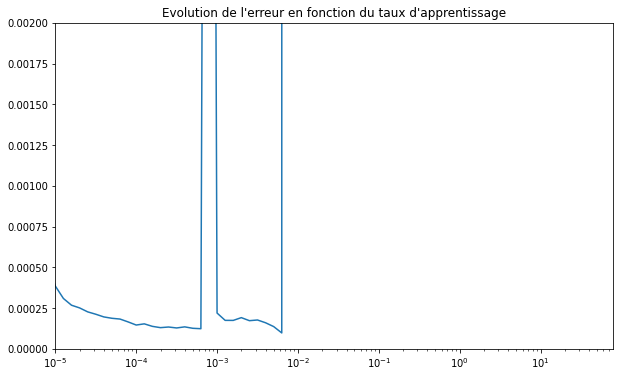

In [38]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[30], taux[99], 0, 0.002])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [66]:
from google.colab import files

max_periodes = 500

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model()

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=10,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)],batch_size=batch_size)

files.download('poids_train.hdf5')

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Epoch 1/500
285/285 [==============================] - 116s 81ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 4.5170e-04 - val_mse: 4.5170e-04

Epoch 00001: loss improved from inf to 0.01273, saving model to poids_train.hdf5
Epoch 2/500
285/285 [==============================] - 7s 26ms/step - loss: 1.0562e-04 - mse: 1.0562e-04 - val_loss: 1.3707e-04 - val_mse: 1.3707e-04

Epoch 00002: loss improved from 0.01273 to 0.00011, saving model to poids_train.hdf5
Epoch 3/500
285/285 [==============================] - 7s 26ms/step - loss: 1.0134e-04 - mse: 1.0134e-04 - val_loss: 9.2871e-05 - val_mse: 9.2871e-05

Epoch 00003: loss improved from 0.00011 to 0.00010, saving model to poids_train.hdf5
Epoch 4/500
285/285 [==============================] - 7s 26ms/step - loss: 9.7030e-05 - mse: 9.7030e-05 - val_loss: 1.3677e-04 - val_mse: 1.3677e-04

Epoch 00004: loss improved from 0.00010 to 0.00010, saving model to poids_train.hdf5
Epoch 5/500
285/285 [==============================] - 7s 26ms/ste

KeyboardInterrupt: ignored

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[100:200])),erreur_entrainement[100:200], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[100:200])),erreur_validation[100:200], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
model.evaluate(x=[x_train[0],x_train[1]],y=y_train)
model.evaluate(x=[x_val[0],x_val[1]],y=y_val)

# Chargement du modèle pré-entrainé

**HRHN**  
  - longueur_sequence = 10      
  - dim_RHN = 128  
  - dim_filtres_cnn = [16,32,64]  
  - nbr_filtres_cnn = [3,3,3]  
  - dim_max_pooling = [3,3,3]  
  - nbr_couches_RHN = 3  
  - dim_motif = auto  
  - drop=0.00  
	=> mse :  3.6047e-05 / 6.2866e-04  


In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Models/HRHN.hdf5"

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  model = get_model()
  model.compile(loss="mse",metrics="mse")
  model.fit(x=[x_train[0],x_train[1]],y=y_train, epochs=1)

In [ ]:
model.load_weights("HRHN.hdf5")

In [ ]:
model.evaluate(x=[x_train[0],x_train[1]],y=y_train)
model.evaluate(x=[x_val[0],x_val[1]],y=y_val)

# Prédictions single-step

In [ ]:
pred_ent = model.predict([x_train[0],x_train[1]],verbose=1)
pred_val = model.predict([x_val[0],x_val[1]],verbose=1)

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en single step**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
print(mse_ent)
print(mse_test)

# Exportation des données

In [ ]:
#Prédictions sur l'entrainement
pred_entrainement = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred_entrainement.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred_entrainement = tf.convert_to_tensor(pred_entrainement).numpy()
pred_entrainement = np.reshape(pred_entrainement,(pred_entrainement.shape[0]*pred_entrainement.shape[1]))

#Prédictions sur les validations
pred_validation = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred_validation.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred_validation = tf.convert_to_tensor(pred_validation).numpy()
pred_validation = np.reshape(pred_validation,(pred_validation.shape[0]*pred_validation.shape[1]))

In [ ]:
df_HRHN_Ent = pd.DataFrame(data=pred_entrainement,columns=['Pred_Ent'])
df_HRHN_Val = pd.DataFrame(data=pred_validation,columns=['Pred_Val'])

In [ ]:
df_HRHN_Ent.to_csv("df_HRHN_Ent.csv")
df_HRHN_Val.to_csv("df_HRHN_Val.csv")

In [ ]:
files.download('df_HRHN_Ent.csv')
files.download('df_HRHN_Val.csv')

# Comparaison DA-RNN / HRHN

Chargement des résultats DA-RNN:

In [ ]:
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/df_DARNN2_Ent.csv"
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/df_DARNN2_Val.csv"
df_DARNN_Ent = pd.read_csv("df_DARNN2_Ent.csv")
df_DARNN_Val = pd.read_csv("df_DARNN2_Val.csv")

In [ ]:
pred_ent = model.predict([x_train[0],x_train[1]],verbose=1)
pred_val = model.predict([x_val[0],x_val[1]],verbose=1)

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='blue', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='red', width=1)))

# Affiche les résultats du DA-RNN
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence-1:temps_separation],y=df_DARNN_Ent['Pred_Ent'],line=dict(color='black', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence-1:],y=df_DARNN_Val['Pred_Val'],line=dict(color='black', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Prédictions naïves

Mettons en place un modèle qui effectue des prédictions naïves sur le NASDAQ :

In [ ]:
class Net_Naif(tf.keras.layers.Layer):
  def __init__(self,longueur_sequence):
    self.longueur_sequence = longueur_sequence
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Sortie séquence Y   : (batch_size,1,1)
  # Sorties :
  #     sortie:   Prédiction Y        : (batch_size,1,1)
  def call(self,input):
    return tf.expand_dims(input[:,-1:,:],-1)                  # (batch_size,1,1)

In [ ]:
def get_model():
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence,1))
  sortie = Net_Naif(longueur_sequence=longueur_sequence)(sorties_sequence)
  model = tf.keras.Model(sorties_sequence,sortie)
  return model

In [ ]:
model_naif = get_model()

In [ ]:
pred_ent = model_naif.predict(x_train[1],verbose=1)
pred_val = model_naif.predict(x_val[1],verbose=1)

In [ ]:
model_naif.compile(loss="mse")
model_naif.evaluate(x=x_train[1],y=y_train)
model_naif.evaluate(x=x_val[1],y=y_val)

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en single step**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
print(mse_ent)
print(mse_test)